## Load MNIST

All the datasets are provided as zip archives. Each archive contains two files -- a training (and validation) set and a test set. We used the last 2000 examples of the training sets as validation sets and, in the case of SVMs, retrained the models with the entire set after choosing the optimal parameters on these validation sets. Data is stored at one example per row, the features being space-separated. There are 784 features per example (=28*28 images), corresponding to the first 784 columns of each row. The last column is the label, which is 0 to 9.

In [1]:
import numpy as np

In [2]:
def load_binarized_mnist(path):
    # rotated
    if "rotated" in path:
        train_x = np.loadtxt(path + "mnist_all_rotation_normalized_float_train_valid.amat")
        test_x = np.loadtxt(path + "mnist_all_rotation_normalized_float_test.amat")

    # mnist
    #train_x = np.loadtxt(path + "mnist_train.amat")
    #test_x = np.loadtxt(path + "mnist_test.amat")
    return train_x, test_x

In [3]:
#train_x, test_x = load_binarized_mnist("../../data/MNIST/mnist/")
train_x, test_x = load_binarized_mnist("../../data/rotatedMNIST/mnist_rotation_new/")

In [4]:
train_x.shape, type(train_x), test_x.shape

((12000, 785), numpy.ndarray, (50000, 785))

-----

## set args

In [6]:
import torch

In [10]:
from tensorboardX import SummaryWriter

class Args():
    gpu_id = 0
    max_len = 10000
    zsize=128
    logdir = "mnist_margin01_data10k"
    model_name = "test_rotmninst"
    device = torch.device("cuda:" + str(gpu_id) if torch.cuda.is_available() else "cpu")
#    data_dir = "../../data/MNIST/mnist/"
    data_dir = "../../data/rotatedMNIST/mnist_rotation_new/"

args = Args()
#writer = SummaryWriter(log_dir="../log/tensorboard/" + args.logdir)


---

## define model

In [11]:
from models.worm2vec_non_sequential import Worm2vec_nonseq
import config

In [12]:
# model
model = Worm2vec_nonseq(zsize=args.zsize)

In [13]:
# ここから実行する場合
model.load_state_dict(torch.load("../models/" + args.model_name + ".pkl"))
model.to(args.device)

Worm2vec_nonseq(
  (enc): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
    (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padd

---

## reshape data

In [15]:
from PIL import Image

def reshape_size(img, size, interpolation=Image.NEAREST):
    def resize_img(img):
        img = Image.fromarray(np.uint8(img), mode="L")
        img = img.resize(size, interpolation)
        img = np.asarray(img)
        return img

    resized_img = np.zeros((img.shape[0], size[0], size[1]))

    for i in range(img.shape[0]):
        resized_img[i, :, :] = resize_img(img[i, :, :])
    return resized_img

def normalize(img, max_value=255):
    return (img - img.min()) / (img.max() - img.min()) * max_value


In [16]:
train_x.min(), train_x.max(), test_x.min(), test_x.max()

(0.0, 9.0, 0.0, 9.0)

In [22]:
# Cut
train_x, test_x = train_x[:args.max_len], test_x[:args.max_len]

# Init
train_X = np.zeros((train_x.shape[0], 28, 28))
test_X = np.zeros((test_x.shape[0], 28, 28))
train_labels = []
test_labels = []

for i, (tr_x, te_x) in enumerate(zip(train_x, test_x)):
    train_X[i, :, :] = np.reshape(tr_x[:-1], (28, 28)).T
    test_X[i, :, :] = np.reshape(te_x[:-1], (28, 28)).T
    train_labels.append(tr_x[-1])
    test_labels.append(te_x[-1])

# Normalize
train_X = normalize(train_X, 255)
test_X = normalize(test_X, 255)

# Reshape (N, 28, 28) into (N, 64, 64)
train_X = reshape_size(train_X, (64, 64))
test_X = reshape_size(test_X, (64, 64))

print(train_X.shape, test_X.shape)

# Reshape (N, H, W) into (N, i, H, W)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1], train_X.shape[2]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1], test_X.shape[2]))

# ToTensor
train_X = torch.from_numpy(train_X).type(torch.float)
test_X = torch.from_numpy(test_X).type(torch.float)

# To GPU
train_X = train_X.to(args.device)
test_X = test_X.to(args.device)

print(train_X.shape, test_X.shape)

(10000, 64, 64) (10000, 64, 64)
torch.Size([10000, 1, 64, 64]) torch.Size([10000, 1, 64, 64])


## embed data

In [23]:
def embedding(model, x):
    embed_x = model.encode(x)
    embed_x = model.m_original(embed_x)
    return embed_x

embed_train_X = embedding(model, train_X)
embed_test_X = embedding(model, test_X)

In [24]:
print("input : ", embed_train_X.shape, embed_test_X.shape)
print("output: ", len(train_labels), len(test_labels))

input :  torch.Size([10000, 64]) torch.Size([10000, 64])
output:  10000 10000


---

## test image plot

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

0 torch.Size([1, 64, 64]) torch.Size([1, 64, 64]) 6.0 6.0


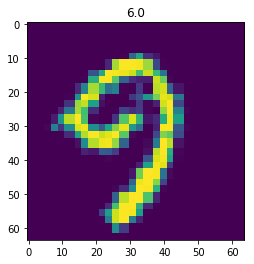

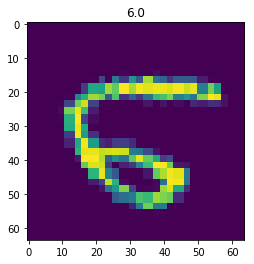

1 torch.Size([1, 64, 64]) torch.Size([1, 64, 64]) 8.0 0.0


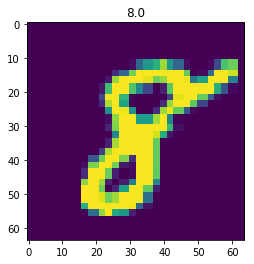

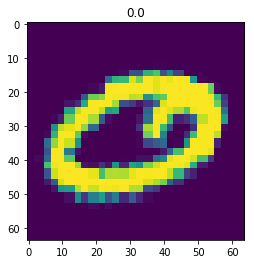

2 torch.Size([1, 64, 64]) torch.Size([1, 64, 64]) 1.0 6.0


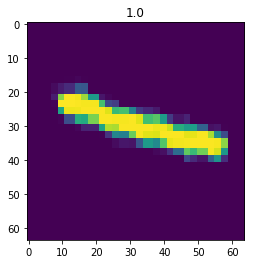

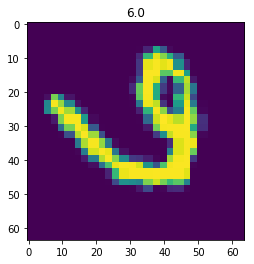

In [26]:
# rotmnist
for i in range(train_X.shape[0]):
    tr, te = train_X[i].cpu(), test_X[i].cpu()
    tr_label, te_label = train_labels[i], test_labels[i]

    print(i, tr.shape, te.shape, tr_label, te_label)

    plt.imshow(np.asarray(tr[0]))
    plt.title(tr_label)
    plt.show()

    plt.imshow(np.asarray(te[0]))
    plt.title(te_label)
    plt.show()
    
    if i > 1:
        break

---

## train

In [35]:
!pip install seaborn

    100% |################################| 225kB 5.3MB/s ta 0:00:01
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [66]:
from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import seaborn as sns

class Classifier_config():
    names = ["RBF SVM",
             "Linear SVM",
             "K Nearest Neighbors",
             "Decision Tree",
             "Random Forest",
             "Neural Net",
             "AdaBoost",
             "Naive Bayes",
             "QDA"
            ]

    classifiers = [svm.SVC(gamma=0.001),
                   svm.SVC(kernel="linear", C=0.001),
                   KNeighborsClassifier(5),
                   DecisionTreeClassifier(max_depth=5),
                   RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                   MLPClassifier(alpha=1, max_iter=1000),
                   AdaBoostClassifier(),
                   GaussianNB(),
                   QuadraticDiscriminantAnalysis()
                  ]

    skip_classifier_name = ["RBF SVM", "Linear SVM", "Decision Tree"]

class Classifier_results():
    def __init__(self):
        self.acc = {}
        self.precision = {}
        self.recall = {}
        self.f1 = {}
    def record(self, classifier_name, acc, precision, recall, f1):
        """
        Args:
            classifier_name ([str])
            acc ([list(int)])
        """
        self.acc[classifier_name] = acc
        self.precision[classifier_name] = precision
        self.recall[classifier_name] = recall
        self.f1[classifier_name] = f1

    def plot(self, metrics_name="acc"):
        if metrics_name=="acc":
            metric = self.acc
        elif metrics_name=="precision":
            metric = self.precision
        elif metrics_name=="recall":
            metric = self.recall
        elif metrics_name=="f1":
            metric = self.f1

        for key, v in metric.items():
            plt.plot(v, label=key)

        plt.ylabel("metrics")
        plt.xlabel("char")
        plt.ylim(0, 1.0)
        plt.legend()
        plt.title("metrics of " + metrics_name)
        plt.show()
    
classify = Classifier_config()
results = Classifier_results()


Skip RBF SVM
Skip Linear SVM
------------
Start K Nearest Neighbors


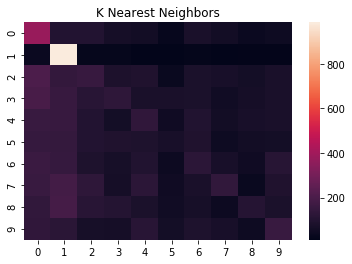

Skip Decision Tree
------------
Start Random Forest


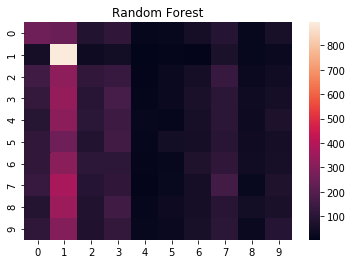

------------
Start Neural Net


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


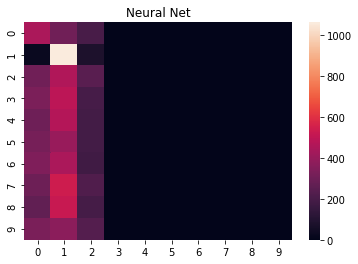

------------
Start AdaBoost


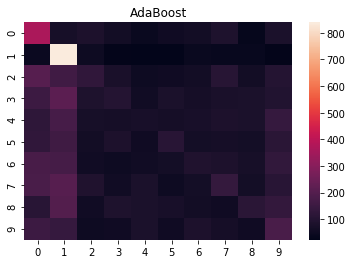

------------
Start Naive Bayes


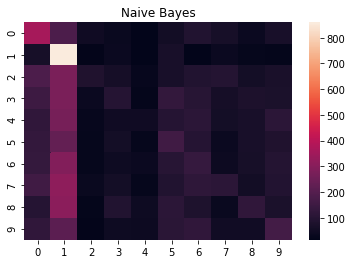

------------
Start QDA


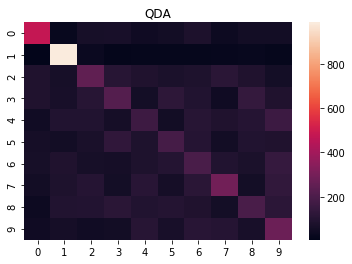

In [67]:

for (classifier, name) in zip(classify.classifiers, classify.names):

    if name in classify.skip_classifier_name:
        print("Skip " + name)
        continue

    print("------------")
    print("Start " + name)

    classifier.fit(embed_train_X.cpu().detach().numpy(), train_labels)

    predicted = classifier.predict(embed_test_X.cpu().detach().numpy())

    # eval
    cm = metrics.confusion_matrix(test_labels, predicted)
    accuracy = metrics.accuracy_score(test_labels, predicted)
    precision = metrics.precision_score(test_labels, predicted, average=None)
    recall = metrics.recall_score(test_labels, predicted, average=None)
    f1 = metrics.f1_score(test_labels, predicted, average=None)

    sns.heatmap(cm)
    plt.title(name)
    plt.show()
    
    # record
    results.record(name, accuracy, precision, recall, f1)

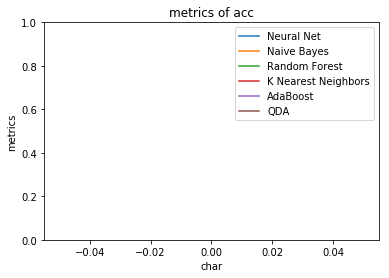

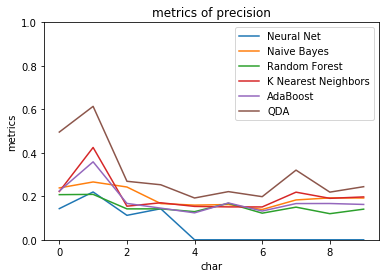

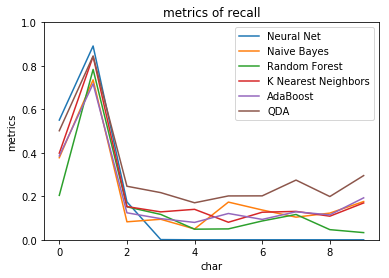

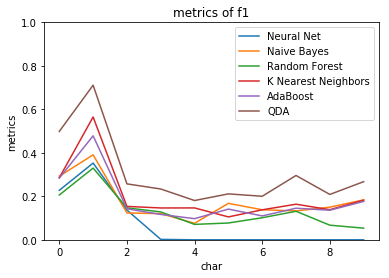

In [65]:
for metrics_name in ["acc", "precision", "recall", "f1"]:
    results.plot(metrics_name=metrics_name)

---